# Exploring LSTM Model on IMS Data

### Learnings from LSTM Implementation
Last week I explored converting IMS satellite data into a sequence of values and passing this data to an LSTM model. From this exploration I observed the following:
1. In the `extract_ims_data_array` function we run a command to `f.seek(1278)`. We run this command to avoid the header of data; however I observed that the header for different date ranges was not consistent. What this means is that we cannot standardize the prcess of proccessing the array data, since we cannnot easily determine where the array starts.
2. After converting some of the data from `bytes` to `ndarray` type I observed that the dimesion of this array was (1024, 1024). Because we are working with grid data, it means that our data is 2-D.
3. LSTM is built with sequences in mind, sequences which are 1-D. So if we convert the grid into 1-D array then we have to run prediction and covert the predicted sequence back to the 2D array. Here we might loose information if the `f.seek(XX)` is not consistent for files on different dates.
Based on my initial exploration, Sequential prediction still makes sense but we might want to move away from traditional LSTM and explore 2-D LSTM or Conv LSTM.
4. When we get outputs from predictions cell values are 6 x 10^-9 instead of 0, which means we would have to perform some additional post processing to get numbers in the origional format
5. I have included a very basic way of calculating MSE however I think it would be helpful to come up with a better metric for accuracy.
6. Once we have normalized the output of our LSTM model, we also need a way to covert the data into a visual, it would be really cool to overlay this mask over an actual map and see what gets rendered.

### Next Steps
1. Create a PR for this code so that others can take a look through it
2. To avoid using the asc files use the hd5 files because you don't have to worry about `f.seek(XX)` and might be easier to
3. Explore Conv LSTM as a better approach for handling 2-D arrays since LSTMS seems to be highly suites for 1-D arrays.

*Note: I started to look through documentation for CONV LSTM but I am not able to find good examples of how it is being used. Might need to take a deep dive into how we can implement these methods.*

In [ ]:
import gzip
import numpy as np

In [ ]:
def extract_ims_data_array(ims_filename):
    with gzip.open("ims1998001_00UTC_24km_v1.1.asc.gz", "rb") as f:
        # Skip 1365 bytes within the header.
        # Take all lines after the header, strip the end-line character and join all in one string.
        f.seek(1278)
        lines = b" ".join(line.strip(b"\n") for line in f)

        # Remove all white space from Lines with Lines.split.
        # If characters (s) in string are digits, convert to integers, then convert to a NumPy Array.
        # Lastly, reshape to 1024 x 1024 24 km resolution.
        ims_data_array = np.reshape(
            np.asarray([int(s) for s in lines.split() if s.isdigit()]), [1024, 1024]
        )

        # From the documentation (Table 3):
        # For unpacked data, integer value of 164 is sea ice, while 165 is snow-covered land.
        # Convert 164 to 3 (sea ice) and 165 to 4 (snow covered land) to align with packed data.
        ims_data_array = np.where(ims_data_array == 164, 3, ims_data_array)
        ims_data_array = np.where(ims_data_array == 165, 4, ims_data_array)

        return ims_data_array

In [ ]:
ims_data_today = extract_ims_data_array("ims1998001_00UTC_24km_v1.1.asc.gz")
# Running flatten command to covert a 2-D array into a 1-D array
ims_data_today_flattened = ims_data_today.flatten()

In [ ]:
ims_data_tomorrow = extract_ims_data_array("ims1998002_00UTC_24km_v1.1.asc.gz")
ims_data_tomorrow_flattened = ims_data_tomorrow.flatten()

### LSTM exploration
Before we commit to working with LSTM, we want to understand how easy it is to initialize a LSTM model and apply it to a dataset. Below is a toy example working with an LSTM model on a comparable data set to the one we will be working with.

Link: https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/

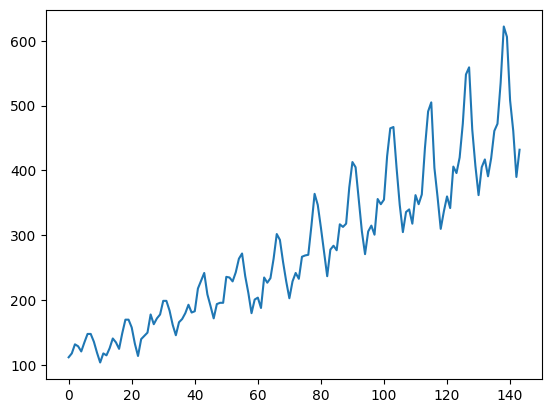

In [ ]:
import pandas
import matplotlib.pyplot as plt

dataset = pandas.read_csv("airline-passengers.csv", usecols=[1], engine="python")
plt.plot(dataset)
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [ ]:
# fix random seed for reproducibility
tf.random.set_seed(7)

In [ ]:
# Load the Data Set
dataframe = pd.read_csv("airline-passengers.csv", usecols=[1], engine="python")
dataset = dataframe.values
dataset = dataset.astype("float32")
(type(dataset), dataset[0:10])

(numpy.ndarray,
 array([[112.],
        [118.],
        [132.],
        [129.],
        [121.],
        [135.],
        [148.],
        [148.],
        [136.],
        [119.]], dtype=float32))

In [ ]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [ ]:
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size : len(dataset), :]
print(len(train), len(test))

96 48


In [ ]:
# convert an array of values into a dataset matrix
import numpy as np


def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i : (i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [ ]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [ ]:
trainX.shape, trainY.shape

((94, 1), (94,))

In [ ]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [ ]:
trainX.shape

(94, 1, 1)

In [ ]:
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss="mean_squared_error", optimizer="adam")
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
94/94 - 2s - loss: 0.0453 - 2s/epoch - 22ms/step
Epoch 2/100
94/94 - 0s - loss: 0.0222 - 162ms/epoch - 2ms/step
Epoch 3/100
94/94 - 0s - loss: 0.0165 - 161ms/epoch - 2ms/step
Epoch 4/100
94/94 - 0s - loss: 0.0152 - 175ms/epoch - 2ms/step
Epoch 5/100
94/94 - 0s - loss: 0.0142 - 168ms/epoch - 2ms/step
Epoch 6/100
94/94 - 0s - loss: 0.0131 - 178ms/epoch - 2ms/step
Epoch 7/100
94/94 - 0s - loss: 0.0122 - 173ms/epoch - 2ms/step
Epoch 8/100
94/94 - 0s - loss: 0.0113 - 161ms/epoch - 2ms/step
Epoch 9/100
94/94 - 0s - loss: 0.0105 - 170ms/epoch - 2ms/step
Epoch 10/100
94/94 - 0s - loss: 0.0095 - 173ms/epoch - 2ms/step
Epoch 11/100
94/94 - 0s - loss: 0.0086 - 167ms/epoch - 2ms/step
Epoch 12/100
94/94 - 0s - loss: 0.0077 - 163ms/epoch - 2ms/step
Epoch 13/100
94/94 - 0s - loss: 0.0069 - 158ms/epoch - 2ms/step
Epoch 14/100
94/94 - 0s - loss: 0.0061 - 155ms/epoch - 2ms/step
Epoch 15/100
94/94 - 0s - loss: 0.0054 - 199ms/epoch - 2ms/step
Epoch 16/100
94/94 - 0s - loss: 0.0048 - 240ms/epoc

In [ ]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:, 0]))
print("Train Score: %.2f RMSE" % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:, 0]))
print("Test Score: %.2f RMSE" % (testScore))

2/2 [==============================] - 0s 6ms/step
Train Score: 23.02 RMSE
Test Score: 48.13 RMSE


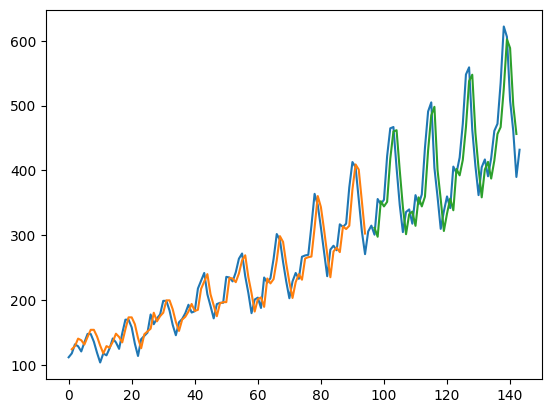

In [ ]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back : len(trainPredict) + look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[
    len(trainPredict) + (look_back * 2) + 1 : len(dataset) - 1, :
] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

## Applying LSTM to IMS Data

In [ ]:
%ls

ims1998001_00UTC_24km_v1.1.asc.gz  ims1998011_00UTC_24km_v1.1.asc.gz
ims1998002_00UTC_24km_v1.1.asc.gz  ims1998012_00UTC_24km_v1.1.asc.gz
ims1998003_00UTC_24km_v1.1.asc.gz  ims1998013_00UTC_24km_v1.1.asc.gz
ims1998004_00UTC_24km_v1.1.asc.gz  ims1998014_00UTC_24km_v1.1.asc.gz
ims1998005_00UTC_24km_v1.1.asc.gz  ims1998015_00UTC_24km_v1.1.asc.gz
ims1998006_00UTC_24km_v1.1.asc.gz  ims1998016_00UTC_24km_v1.1.asc.gz
ims1998007_00UTC_24km_v1.1.asc.gz  ims1998017_00UTC_24km_v1.1.asc.gz
ims1998008_00UTC_24km_v1.1.asc.gz  ims1998018_00UTC_24km_v1.1.asc.gz
ims1998009_00UTC_24km_v1.1.asc.gz  ims1998019_00UTC_24km_v1.1.asc.gz
ims1998010_00UTC_24km_v1.1.asc.gz  ims1998020_00UTC_24km_v1.1.asc.gz


In [ ]:
ims_dataset = []
for i in range(1, 21, 1):
    ims_data_filename = f"content/ims_dataset/ims199800{i}_00UTC_24km_v1.1.asc.gz"
    # print(f'ims_data_filename: {ims_data_filename}')
    ims_data_today_flattened = ims_data_today.flatten()
    ims_dataset.append(ims_data_today_flattened)
ims_dataset = np.array(ims_dataset)

In [ ]:
dataset = ims_dataset
dataset.shape, dataset

((20, 1048576),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]))

In [ ]:
dataset = scaler.fit_transform(dataset)

In [ ]:
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size : len(dataset), :]
print(len(train), len(test))

13 7


In [ ]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i : (i + look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back])
    return np.array(dataX), np.array(dataY)

In [ ]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [ ]:
trainX.shape, trainY.shape

((11, 1, 1048576), (11, 1048576))

In [ ]:
testX.shape, testY.shape

((5, 1, 1048576), (5, 1048576))

In [ ]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[2]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[2]))

In [ ]:
trainX.shape, testX.shape

((11, 1, 1048576), (5, 1, 1048576))

In [ ]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, trainX.shape[2])))
model.add(Dense(trainX.shape[2]))
model.compile(loss="mean_squared_error", optimizer="adam")
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
11/11 - 7s - loss: 1.4922 - 7s/epoch - 632ms/step
Epoch 2/100
11/11 - 6s - loss: 1.4794 - 6s/epoch - 500ms/step
Epoch 3/100
11/11 - 5s - loss: 1.4659 - 5s/epoch - 450ms/step
Epoch 4/100
11/11 - 4s - loss: 1.4522 - 4s/epoch - 359ms/step
Epoch 5/100
11/11 - 4s - loss: 1.4384 - 4s/epoch - 358ms/step
Epoch 6/100
11/11 - 5s - loss: 1.4247 - 5s/epoch - 435ms/step
Epoch 7/100
11/11 - 4s - loss: 1.4110 - 4s/epoch - 366ms/step
Epoch 8/100
11/11 - 4s - loss: 1.3974 - 4s/epoch - 356ms/step
Epoch 9/100
11/11 - 5s - loss: 1.3838 - 5s/epoch - 434ms/step
Epoch 10/100
11/11 - 4s - loss: 1.3702 - 4s/epoch - 372ms/step
Epoch 11/100
11/11 - 4s - loss: 1.3568 - 4s/epoch - 347ms/step
Epoch 12/100
11/11 - 4s - loss: 1.3434 - 4s/epoch - 403ms/step
Epoch 13/100
11/11 - 4s - loss: 1.3301 - 4s/epoch - 389ms/step
Epoch 14/100
11/11 - 4s - loss: 1.3169 - 4s/epoch - 352ms/step
Epoch 15/100
11/11 - 4s - loss: 1.3038 - 4s/epoch - 384ms/step
Epoch 16/100
11/11 - 4s - loss: 1.2907 - 4s/epoch - 407ms/step
E

In [ ]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
testPredict.shape, testPredict, testPredict[0]

1/1 [==============================] - 0s 129ms/step


((5, 1048576),
 array([[ 1.5716068e-09,  2.7939677e-09, -6.9849193e-10, ...,
         -6.9849193e-10, -1.5716068e-09,  1.5716068e-09],
        [ 1.5716068e-09,  2.7939677e-09, -6.9849193e-10, ...,
         -6.9849193e-10, -1.5716068e-09,  1.5716068e-09],
        [ 1.5716068e-09,  2.7939677e-09, -6.9849193e-10, ...,
         -6.9849193e-10, -1.5716068e-09,  1.5716068e-09],
        [ 1.5716068e-09,  2.7939677e-09, -6.9849193e-10, ...,
         -6.9849193e-10, -1.5716068e-09,  1.5716068e-09],
        [ 1.5716068e-09,  2.7939677e-09, -6.9849193e-10, ...,
         -6.9849193e-10, -1.5716068e-09,  1.5716068e-09]], dtype=float32),
 array([ 1.5716068e-09,  2.7939677e-09, -6.9849193e-10, ...,
        -6.9849193e-10, -1.5716068e-09,  1.5716068e-09], dtype=float32))

In [ ]:
# We can reshape the output dataframe into the origional format
testPredict[0].reshape(1024, 1024)

array([[ 1.5716068e-09,  2.7939677e-09, -6.9849193e-10, ...,
        -2.7939677e-09,  3.4924597e-10, -1.3969839e-09],
       [-3.9290171e-10,  1.5716068e-09, -2.1827873e-11, ...,
         1.3969839e-09, -2.7939677e-09,  3.4924597e-10],
       [-1.5716068e-09,  1.3969839e-09,  6.9849193e-10, ...,
         1.3969839e-09,  2.7939677e-09,  3.9290171e-10],
       ...,
       [ 2.7939677e-09,  2.7939677e-09,  7.8580342e-10, ...,
        -1.3969839e-09,  2.7939677e-09, -1.7462298e-10],
       [-3.9290171e-10,  1.7462298e-10, -1.3969839e-09, ...,
         1.3969839e-09, -1.5716068e-09,  6.9849193e-10],
       [ 1.3969839e-09, -1.5716068e-09, -4.3655746e-11, ...,
        -6.9849193e-10, -1.5716068e-09,  1.5716068e-09]], dtype=float32)

In [ ]:
trainY.shape

(11, 1048576)

In [ ]:
A = trainPredict[0]
B = testY[0]
mse = ((A - B) ** 2).mean()
mse

17.60624779000648

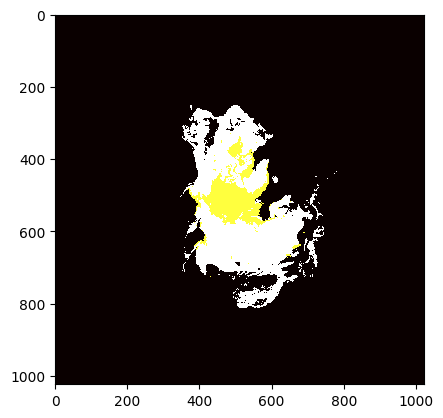

In [ ]:
plt.imshow(testPredict[0].reshape(1024, 1024), cmap="hot", interpolation="nearest")
plt.show()

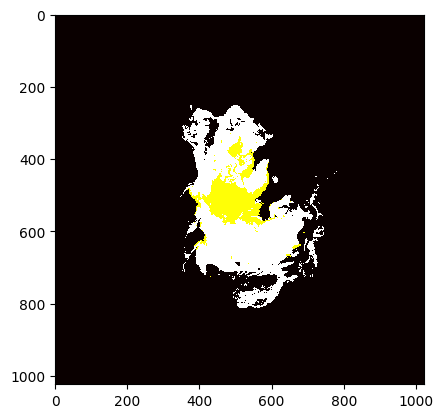

In [ ]:
plt.imshow(testY[0].reshape(1024, 1024), cmap="hot", interpolation="nearest")
plt.show()